In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
import mxnet as mx
import numpy as np

from sklearn import svm
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import os
import sys
import math
import time
import pickle

proj_dir = os.getcwd()
label_dir = os.path.join(proj_dir, 'emotiondetection/features_labels_lld/labels')
lld_dir = os.path.join(proj_dir, 'emotiondetection/features_labels_lld/lld')

pickle_train_y_list = 'pickle_train_y_list'
pickle_train_x_list = 'pickle_train_x_list'

pickle_test_y_list = 'pickle_test_y_list'
pickle_test_x_list = 'pickle_test_x_list'

In [3]:
mfcc_dir = os.path.join(proj_dir, 'emotiondetection/mfcc_csv')

pickle_train_mfcc_x_list = 'pickle_train_mfcc_x_list'

pickle_test_mfcc_x_list = 'pickle_test_mfcc_x_list'

In [4]:
train_y_list = pickle.load(open(pickle_train_y_list))
train_x_list = pickle.load(open(pickle_train_x_list))

test_y_list = pickle.load(open(pickle_test_y_list))
test_x_list = pickle.load(open(pickle_test_x_list))


train_mfcc_x_list = pickle.load(open(pickle_train_mfcc_x_list))

test_mfcc_x_list = pickle.load(open(pickle_test_mfcc_x_list))

In [5]:
from sklearn.metrics import confusion_matrix
import itertools
def calc_score(test_y_list, predict_y_list):
    print "Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):"
    print 'macro   : ', metrics.precision_recall_fscore_support(test_y_list, predict_y_list, average='macro')
    print 'weighted: ', metrics.precision_recall_fscore_support(test_y_list, predict_y_list, average='weighted')
    print metrics.precision_recall_fscore_support(test_y_list, predict_y_list)
    print confusion_matrix(test_y_list, predict_y_list)

In [6]:
# # z-score normalization
# scaler = preprocessing.StandardScaler().fit(train_x_list)
# train_x_list = scaler.transform(train_x_list)
# test_x_list = scaler.transform(test_x_list)

In [7]:
print train_y_list.shape, train_x_list.shape
print test_y_list.shape, test_x_list.shape

(9959,) (9959, 384)
(8257,) (8257, 384)


In [8]:
print train_x_list[0][:10]
print test_x_list[0][:10]

[  5.66733100e-03   3.11773100e-04   5.35555800e-03   5.30000000e+01
   9.60000000e+01   1.30774500e-03   4.18643100e-06   1.09633100e-03
   1.80239600e-06   1.34818000e-03]
[  1.23016500e-02   9.11361400e-05   1.22105100e-02   5.20000000e+01
   2.40000000e+01   1.31725500e-03   3.23349300e-07   1.29866300e-03
   6.89166500e-06   2.62522000e-03]


In [9]:
# TODO Just for pre-test
train_y_list = train_y_list[:200]
test_y_list = test_y_list[:200]
train_mfcc_x_list = train_mfcc_x_list[:200]
test_mfcc_x_list = test_mfcc_x_list[:200]

In [10]:
# window size
w = 10

# generate training segment data
full_X = []
full_y = []

for i in xrange(len(train_mfcc_x_list)):
    tmp_mfcc_x = train_mfcc_x_list[i]
    tmp_y = train_y_list[i]
    
    frame_count = len(tmp_mfcc_x)
    for j in xrange(frame_count - 2*w):
        tmp_x = np.concatenate(tmp_mfcc_x[j: j+2*w+1])
        full_X.append(tmp_x)
        full_y.append(tmp_y)

full_X = np.array(full_X)
full_y = np.array(full_y)
print 'train:', full_X.shape, full_y.shape

# generate test segment data
full_test_X = []
full_test_y = []

for i in xrange(len(test_mfcc_x_list)):
    tmp_mfcc_x = test_mfcc_x_list[i]
    tmp_y = test_y_list[i]
    
    frame_count = len(tmp_mfcc_x)
    for j in xrange(frame_count - 2*w):
        tmp_x = np.concatenate(tmp_mfcc_x[j: j+2*w+1])
        full_test_X.append(tmp_x)
        full_test_y.append(tmp_y)

full_test_X = np.array(full_test_X)
full_test_y = np.array(full_test_y)
print 'test:', full_test_X.shape, full_test_y.shape

train: (33386, 819) (33386,)
test: (29978, 819) (29978,)


In [11]:
# prefix = 'results_gpu/DNN_1024_sig_1024_sig_5'
# epochs = 100

# prefix = 'results_cpu_tmp/DNN_1024_sig_1024_sig_5'
# epochs = 5

prefix = 'results_cpu/DNN_2048_sig_5'
epochs = 100

In [12]:
model_loaded = mx.model.FeedForward.load(prefix, epochs)

127
165
(165, 819)
(165, 5)


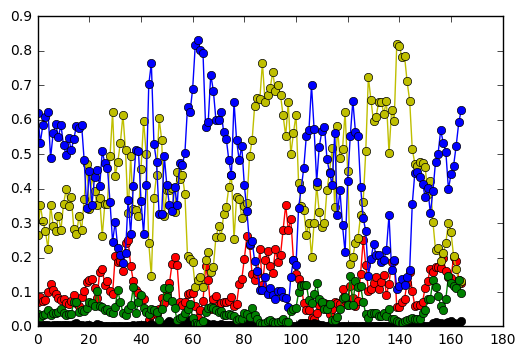

128
118
(118, 819)
(118, 5)


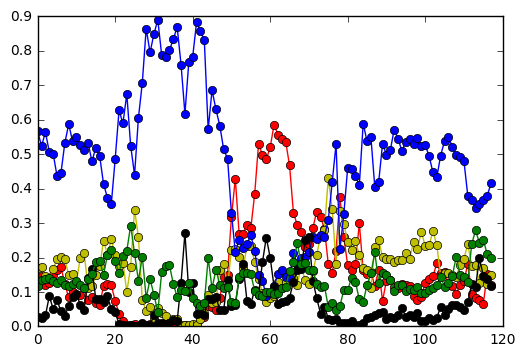

129
130
(130, 819)
(130, 5)


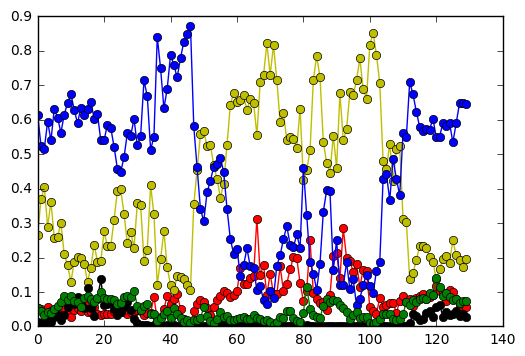

130
112
(112, 819)
(112, 5)


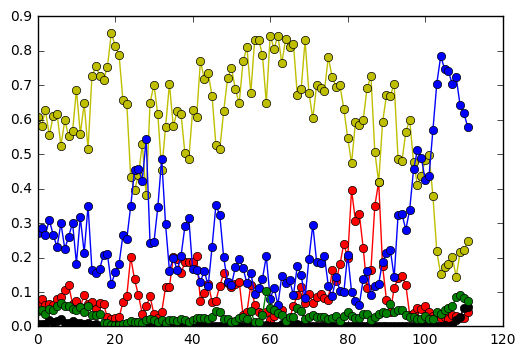

131
192
(192, 819)
(192, 5)


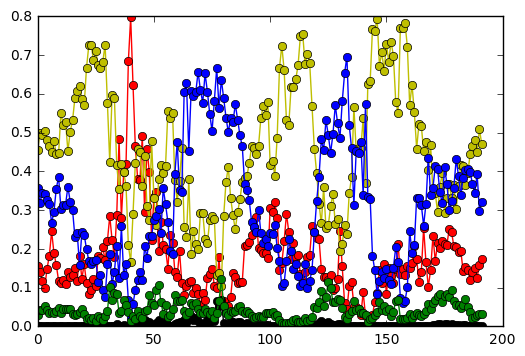

In [16]:
for index in xrange(127, 132):
#     index = 5
    print index
    start_i = 0
    for ind in xrange(index):
        tt_mfcc_x = train_mfcc_x_list[ind]
        tt_frame_count = len(tt_mfcc_x) - 2*w
        start_i += tt_frame_count

    tt_mfcc_x = train_mfcc_x_list[index]
    tt_frame_count = len(tt_mfcc_x) - 2*w
    print tt_frame_count

    tt_x_list = full_X[start_i: start_i+tt_frame_count]
    print tt_x_list.shape

    tt_predict_y_score_list = model_loaded.predict(tt_x_list)
    print tt_predict_y_score_list.shape

    color_list = ['r', 'y', 'b', 'k', 'g']
    for i in xrange(5):
        xxx = np.arange(tt_frame_count)
        yyy = tt_predict_y_score_list[:,i]
        plt.plot(xxx, yyy, 'o-', color=color_list[i])
    plt.show()

In [14]:
print test_y_list[:100]
print test_y_list[100:200]

[2 2 2 2 2 4 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 2 2 2 2 2 2 2 1 1 2 1 1 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2
 1 1 1 2 1 1 1 1 1 2 2 1 1 1 2 1 1 2 2 2 2 2 1 1 1 2]
[2 2 2 2 2 1 1 1 1 2 2 4 1 1 2 2 2 2 1 2 0 0 2 2 2 2 2 1 0 0 0 1 1 1 1 3 2
 2 1 2 1 1 1 1 1 2 1 1 1 0 1 0 0 1 2 1 2 2 1 1 2 0 1 1 2 2 2 2 2 2 1 1 2 1
 1 2 2 2 2 1 2 1 2 2 2 1 2 1 2 1 2 2 1 2 2 2 2 2 1 1]


In [15]:
print test_y_list[5]
print test_y_list[14]
print test_y_list[15]
print test_y_list[16]
print test_y_list[35]
print test_y_list[36]
print test_y_list[37]
print test_y_list[45]
print test_y_list[46]
print test_y_list[48]
print test_y_list[49]
print test_y_list[53]
print test_y_list[54]
print '------'
print test_y_list[128]
print test_y_list[129]
print test_y_list[130]
print test_y_list[131]
print test_y_list[132]
print test_y_list[133]
print test_y_list[134]
print test_y_list[135]

4
1
1
1
1
1
1
1
1
1
1
0
1
------
0
0
0
1
1
1
1
3


# generate segment level feature

In [41]:
seg_thresholds = [0.2, 0.6, 0.6, 0.1, 0.1]

def getSegFeatList(mfcc_x_list):
    x_seg_list = []
    for index in xrange(len(mfcc_x_list)):
    #     print index
        start_i = 0
        for ind in xrange(index):
            tt_mfcc_x = mfcc_x_list[ind]
            tt_frame_count = len(tt_mfcc_x) - 2*w if len(tt_mfcc_x) - 2*w > 0 else 1
            start_i += tt_frame_count

        tt_mfcc_x = mfcc_x_list[index]
        tt_frame_count = len(tt_mfcc_x) - 2*w if len(tt_mfcc_x) - 2*w > 0 else 1
        tt_x_list = full_X[start_i: start_i+tt_frame_count]
        tt_predict_y_score_list = model_loaded.predict(tt_x_list)

        f1 = np.max(tt_predict_y_score_list, axis=0)
        f2 = np.min(tt_predict_y_score_list, axis=0)
        f3 = np.mean(tt_predict_y_score_list, axis=0)
        f4 = np.sum(tt_predict_y_score_list > seg_thresholds, axis=0).astype(float) / len(tt_predict_y_score_list)
        
        x_seg_list.append(np.concatenate([f1, f2, f3, f4]))
    x_seg_list = np.array(x_seg_list)
    return x_seg_list

train_x_seg_list = getSegFeatList(train_mfcc_x_list)
test_x_seg_list = getSegFeatList(test_mfcc_x_list)
print train_x_seg_list.shape, test_x_seg_list.shape

(200, 20) (200, 20)


# construct SVM

In [42]:
# SVM 
print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

clf = svm.SVC().fit(train_x_seg_list, train_y_list)
print clf
predict_y_list = clf.predict(test_x_seg_list)
calc_score(test_y_list, predict_y_list)

print 'end:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

start: 2017-01-03 12:38:45
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.11799999999999999, 0.20000000000000001, 0.14842767295597487, None)
weighted:  (0.34809999999999997, 0.58999999999999997, 0.43786163522012578, None)
(array([ 0.  ,  0.  ,  0.59,  0.  ,  0.  ]), array([ 0.,  0.,  1.,  0.,  0.]), array([ 0.        ,  0.        ,  0.74213836,  0.        ,  0.        ]), array([ 10,  69, 118,   1,   2]))
[[  0   0  10   0   0]
 [  0   0  69   0   0]
 [  0   0 118   0   0]
 [  0   0   1   0   0]
 [  0   0   2   0   0]]
end: 2017-01-03 12:38:45


/home/slhome/cc001/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
pickle.dump(predict_y_list, open(prefix+'-'+str(int(time.time()))+'-'+'pred_y.pkl', 'w'))

In [43]:
# SVM with class_weight='balanced'
print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

clf = svm.SVC(class_weight='balanced').fit(train_x_seg_list, train_y_list)
print clf
predict_y_list = clf.predict(test_x_seg_list)
calc_score(test_y_list, predict_y_list)

print 'end:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

start: 2017-01-03 12:38:50
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.22786974219810041, 0.13385408990420045, 0.15504090377873006, None)
weighted:  (0.51948439620081421, 0.245, 0.30609125438254775, None)
(array([ 0.1       ,  0.40298507,  0.63636364,  0.        ,  0.        ]), array([ 0.1       ,  0.39130435,  0.1779661 ,  0.        ,  0.        ]), array([ 0.1       ,  0.39705882,  0.2781457 ,  0.        ,  0.        ]), array([ 10,  69, 118,   1,   2]))
[[ 1  4  1  1  3]
 [ 3 27  9  3 27]
 [ 6 35 21 10 46]
 [ 0  0  1  0  0]
 [ 0  1  1  0  0]]
end: 2017-01-03 12:38:51


In [ ]:
pickle.dump(predict_y_list, open(prefix+'-'+str(int(time.time()))+'-'+'pred_y.pkl', 'w'))